In [1]:
import torch
import torch.nn as nn
import torchvision

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import os

from torch.utils.data import Dataset, DataLoader
# from torch.utils.data.sampler import Sampler
import torch.optim as optim
import sys
sys.path.append('../')

from dataset import LbpDataset, train_transforms, val_transforms, test_transforms, collate_fn, get_data
from visualize import visualize
from rcnn_model import FastRCNNPredictor
from engine import evaluate
import utils
from train_lbp import get_train_test_list
from torchvision.models.detection.faster_rcnn import fasterrcnn_resnet50_fpn

In [2]:
import easydict 
args = easydict.EasyDict({ "batch_size": 2, 
                          "epochs": 50, 
                          "data": 0, 
                          'lr':0.1,
                         'momentum':0.9,
                         'weight_decay':1e-4,
                         'start_epoch':0,
                         'gpu':5,
                          'workers':2})

In [3]:
df = pd.read_csv('../../data/df.csv')
df.head()



,ID,file_name,task,bbox,xmin,ymin,w,h,label,occluded,des,cell_type
0,0,patch_images/2021.01.12/LBC305-20210108(1)/LBC...,[ASCUS] LBC305,"[56, 35, 1980, 1985]",56,35,1980,1985,판독불가,0,NaN,NaN
1,1,patch_images/2021.01.12/LBC305-20210108(1)/LBC...,[ASCUS] LBC305,"[56, 30, 1912, 1937]",56,30,1912,1937,판독불가,0,NaN,NaN
2,2,patch_images/2021.01.12/LBC305-20210108(1)/LBC...,[ASCUS] LBC305,"[21, 12, 2010, 2027]",21,12,2010,2027,판독불가,0,NaN,NaN
3,3,patch_images/2021.01.06/LBC37-20210102(1)/LBC3...,[ASCUS] LBC37,"[1349, 420, 100, 113]",1349,420,100,113,ASC-US,0,NaN,Atypical squamous cells of undetermined signif...
4,4,patch_images/2021.01.06/LBC37-20210102(1)/LBC3...,[ASCUS] LBC37,"[1575, 720, 163, 213]",1575,720,163,213,ASC-US,0,NaN,Atypical squamous cells of undetermined signif...


In [4]:
data_dir = '../../data/df.csv'
train_list, test_list = get_train_test_list(data_dir)
train_dataset = LbpDataset(train_list, transform=train_transforms)
test_dataset = LbpDataset(test_list, transform=val_transforms)  

total 4019 train 3014 test 1005
3014
1005


In [35]:
# images,targets = next(iter(train_dataset))
images

tensor([[[1.8037, 1.7352, 1.6838,  ..., 1.1700, 1.0673, 1.0673],
         [1.9407, 1.8722, 1.8037,  ..., 1.1015, 1.0331, 1.0159],
         [2.0092, 1.9407, 1.8722,  ..., 1.1187, 1.0502, 1.0159],
         ...,
         [1.3584, 1.2728, 1.1872,  ..., 1.8037, 1.7865, 1.7523],
         [1.2899, 0.7591, 0.5707,  ..., 1.7865, 1.7352, 1.7694],
         [0.8276, 0.2282, 0.3652,  ..., 1.8037, 1.7694, 1.7352]],

        [[1.6583, 1.5707, 1.4657,  ..., 0.4503, 0.3452, 0.3452],
         [1.8508, 1.7458, 1.6408,  ..., 0.3978, 0.3277, 0.2927],
         [1.9909, 1.9034, 1.8158,  ..., 0.3978, 0.3102, 0.2927],
         ...,
         [1.5182, 1.4307, 1.3256,  ..., 1.9559, 1.9384, 1.8859],
         [1.4657, 0.8880, 0.6429,  ..., 1.9384, 1.9034, 1.9384],
         [0.9580, 0.2752, 0.3978,  ..., 1.9559, 1.9559, 1.9384]],

        [[1.9080, 1.8731, 1.8383,  ..., 0.9668, 0.8797, 0.9842],
         [2.1520, 2.0474, 1.9603,  ..., 1.0191, 0.9494, 0.9145],
         [2.2740, 2.2043, 2.1171,  ..., 1.0017, 0.9145, 0.

In [36]:
# test_sampler = torch.utils.data.SequentialSampler(test_dataset)
# data_loader_test = torch.utils.data.DataLoader(
#     test_dataset, batch_size=args.batch_size,
#     sampler=test_sampler, num_workers=args.workers,
#     collate_fn=utils.collate_fn)
data_loader_test = torch.utils.data.DataLoader(
    test_dataset, batch_size=args.batch_size,
    sampler=None,shuffle=False, num_workers=args.workers,
    collate_fn=utils.collate_fn)

In [37]:
# images,targets = next(iter(data_loader_test))

In [38]:
# targets

In [39]:
num_classes = 2
model = fasterrcnn_resnet50_fpn(pretrained=True, min_size=1024, max_size=1024, box_nms_thresh=0.3)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
checkpoint = torch.load('../trained_model/fasterrcnn_resnet50_fpn/checkpoint.pth')
model.load_state_dict(checkpoint['model'])
device = torch.device('cpu')
model.to(device)
print('model is loaded to gpu')

model is loaded to gpu


In [57]:
# images, targets = next(iter(data_loader_test))
# print(images)

In [60]:
model.eval()

images, targets = next(iter(data_loader_test))
# print(type(images))
print(images[0][:,0,0])
images = list(img.to(device) for img in images)
with torch.no_grad():
    outputs = model(images)
#     outputs = [{k: v.to(device) for k, v in t.items()} for t in outputs]
    
# images = [image.to('cpu') for image in images]
# outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]    
# # print(targets)
print(targets[0]['boxes'])
print(targets[0]['image_id'])
print(type(targets[0]['image_id']))

tensor([0.6563, 0.6779, 1.1585])
tensor([[475.0000, 279.5000, 566.0000, 379.5000]])
tensor([3972])
<class 'torch.Tensor'>


[0.6563062 0.6778712 1.1585187]
(3, 1024, 1024)
patch_images/2021.01.07/LBC70-20210104(1)/LBC70-20210104(1)_460.png
tensor([0.9949, 0.6353, 0.2077, 0.1894, 0.1010])
(1024, 1024, 3)


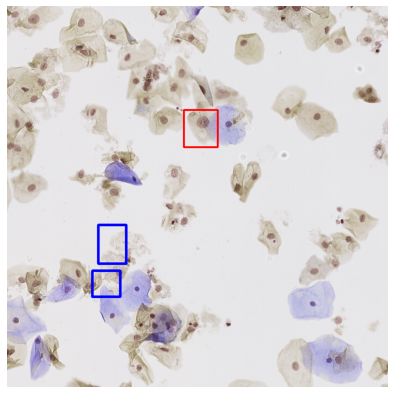

In [81]:
IMAGE_NUM = 0
image = images[IMAGE_NUM].numpy()
print(image[:,0,0])
print(image.shape)
image = np.transpose(image, (1, 2, 0))
img_id = targets[IMAGE_NUM]['image_id'][0].numpy()
img_path = df[df['ID']==img_id].file_name.values[0]
print(img_path)
ground_boxes = targets[IMAGE_NUM]['boxes']
out_boxes = outputs[IMAGE_NUM]['boxes']
out_scores = outputs[IMAGE_NUM]['scores']
print(out_scores)

pred_boxes = []
for b, s in zip(out_boxes, out_scores) :
    if s > 0.5 :
        pred_boxes.append(b.numpy())
        
import cv2
abs_path = '/home/Dataset/scl/'
image = cv2.imread(abs_path + img_path)
image = cv2.resize(image, dsize=(1024,1024))
# print(image.shape)
visualize(image, ground_boxes, pred_boxes)        

In [82]:
IMAGE_NUM = 1
image = images[IMAGE_NUM].numpy()
print(image.shape)
print(image[:,0,0])
image = np.transpose(image, (1, 2, 0))
img_id = targets[IMAGE_NUM]['image_id'][0].numpy()
img_path = df[df['ID']==img_id].file_name.values[0]
print(img_path)
ground_boxes = targets[IMAGE_NUM]['boxes']
out_boxes = outputs[IMAGE_NUM]['boxes']
out_scores = outputs[IMAGE_NUM]['scores']
out_labels = outputs[IMAGE_NUM]['labels']
print(out_scores)

pred_boxes = []
pred_scores = []
pred_labels = []
for b, s, l in zip(out_boxes, out_scores, out_labels) :
    if s > 0.5 :
        pred_boxes.append(b.numpy())
        pred_scores.append(s.numpy())
        pred_labels.append(l.numpy())
        
import cv2
abs_path = '/home/Dataset/scl/'
image = cv2.imread(abs_path + img_path)
print(image)
image = cv2.resize(image, dsize=(1024,1024))
# print(image.shape)
visualize(image, ground_boxes, pred_boxes)        

(3, 1024, 1024)
[1.8207895 1.9908963 2.2391288]
patch_images/2021.01.14/LBC404-20210111(1)/LBC404-20210111(1)_1531.png


IndexError: list index out of range

In [23]:
# from engine import evaluate
# evaluate(model, data_loader_test, device=device)

(1024, 1024, 3)

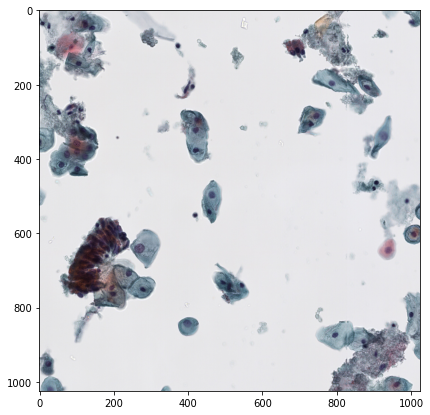

In [66]:
image = cv2.imread('../LBC404_1531.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (1024, 1024))
plt.figure(figsize=(7, 7))
plt.imshow(image)
image.shape
# print(image[:,0,0])

In [25]:
image_mean = torch.tensor([0.485, 0.456, 0.406])
image_std = torch.tensor([0.229, 0.224, 0.225])

In [105]:
image = cv2.imread('../LBC404_1531.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (1024, 1024))

image = torch.from_numpy(image).permute(2,0,1)
print(image.shape)
image = (image)/255.
image = (image - image_mean[:, None, None]) / image_std[:, None, None]
image = image.unsqueeze_(dim=0)
print(image[0,:,0,0])
image = list(img.to(device) for img in image)
with torch.no_grad():
    model.eval()
    outputs = model(image)
#     outputs = [{k: v.to(device) for k, v in t.items()} for t in outputs]
    
out_boxes = outputs[0]['boxes']
out_scores = outputs[0]['scores']
out_labels = outputs[0]['labels']    

pred_boxes = []
pred_scores = []
pred_labels = []
for b, s, l in zip(out_boxes, out_scores, out_labels) :
    if s > 0.5 :
        pred_boxes.append(b.numpy())
        pred_scores.append(s.numpy())
        pred_labels.append(l.numpy())

print(pred_boxes)

torch.Size([3, 1024, 1024])
tensor([1.8208, 1.9909, 2.2391])
[array([245.30214, 588.5557 , 320.8527 , 692.36676], dtype=float32), array([229.28543, 711.2612 , 304.97794, 781.5796 ], dtype=float32)]


(1024, 1024, 3)


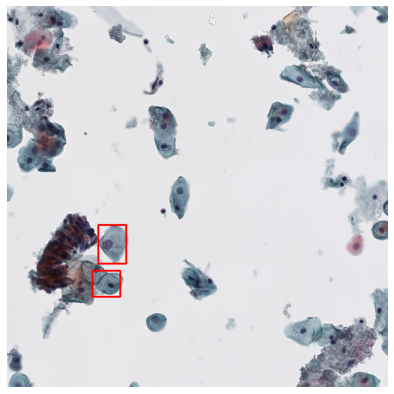

In [98]:
image = cv2.imread('../LBC404_1531.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (1024, 1024))
# print(pred_boxes)    
visualize(image, pred_boxes)         

In [101]:
from dataset import test_transforms, val_transforms
image = cv2.imread('../LBC404_1531.png')
# print(image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (1024, 1024))
# transformed = test_transforms(image=image)
transformed = val_transforms(image=image, bboxes=[[0.,0.,1.,1.]], labels=[0])
image = transformed['image']
# image = image/255.
image = (image - image_mean[:, None, None]) / image_std[:, None, None]
image = image.unsqueeze_(dim=0)
print(image[0,:,0,0])

image = list(img.to(device) for img in image)
with torch.no_grad():
    model.eval()
    outputs = model(image)
    outputs = [{k: v.to(device) for k, v in t.items()} for t in outputs]
    
out_boxes = outputs[0]['boxes']
out_scores = outputs[0]['scores']
out_labels = outputs[0]['labels']    

pred_boxes = []
pred_scores = []
pred_labels = []
for b, s, l in zip(out_boxes, out_scores, out_labels) :
    if s > 0.5 :
        pred_boxes.append(b.numpy())
        pred_scores.append(s.numpy())
        pred_labels.append(l.numpy())    
print(pred_boxes)        

tensor([1.8208, 1.9909, 2.2391])
[array([245.30214, 588.5557 , 320.8527 , 692.36676], dtype=float32), array([229.28543, 711.2612 , 304.97794, 781.5796 ], dtype=float32)]


[0.90588235 0.89803922 0.89803922]
(1024, 1024, 3)


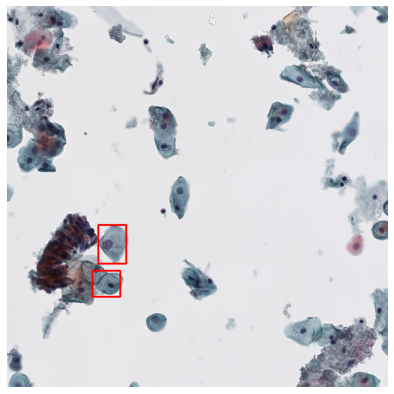

In [106]:
image = cv2.imread('../LBC404_1531.png')
# image = cv2.imread('/home/Dataset/scl/patch_images/2021.01.14/LBC404-20210111(1)/LBC404-20210111(1)_1531.png')

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (1024, 1024))
# print(pred_boxes)    
visualize(image, pred_boxes)         